In [1]:
import numpy as np
from sus.protocol_designer import System, Protocol, Potential, Compound_Protocol
from sus.protocol_designer.protocol import sequential_protocol
from IPython import display
from IPython.display import HTML
from quick_sim import setup_sim
from edward_tools.coupled_fq_potential import coupled_flux_qubit_pot, coupled_flux_qubit_force, coupled_fq_pot
import edward_tools.fq_runner as fq_runner
from edward_tools.visualization import animate_sim_flux_qubit

import kyle_tools as kt
import matplotlib.pyplot as plt

import importlib, os
from edward_tools import coupled_fq_protocol_library, cfq_runner
from PARAMETER_INPUT import *
from PARAMETER_INPUT import _lambda, _theta, _eta
from ControlParameter import *

from edward_tools import coupled_fq_protocol_library
import edward_tools.cfq_batch_sweep as cfq_batch_sweep

coupled_fq_protocol_library = importlib.reload(coupled_fq_protocol_library)
create_system = coupled_fq_protocol_library.create_system
get_potential_shot_at_different_t = coupled_fq_protocol_library.get_potential_shot_at_different_t
get_potential_shot_at_different_t_1D = coupled_fq_protocol_library.get_potential_shot_at_different_t_1D
create_simple_protocol_parameter_dict = coupled_fq_protocol_library.create_simple_protocol_parameter_dict
create_system_from_storage_and_computation_protocol = coupled_fq_protocol_library.create_system_from_storage_and_computation_protocol
coupled_fq_runner = importlib.reload(cfq_runner)
coupled_fq_protocol_library = importlib.reload(coupled_fq_protocol_library)
create_system = coupled_fq_protocol_library.create_system


# 4. Szilard engine test

In [2]:
import numpy as np
from sus.protocol_designer import System, Protocol, Potential, Compound_Protocol
from sus.protocol_designer.protocol import sequential_protocol
from IPython.display import HTML
from quick_sim import setup_sim
from edward_tools.coupled_fq_potential import coupled_flux_qubit_pot, coupled_flux_qubit_force, coupled_fq_pot
from edward_tools.visualization import animate_sim_flux_qubit
import kyle_tools as kt
import matplotlib.pyplot as plt
import importlib, os, hashlib, json
from edward_tools import coupled_fq_protocol_library, cfq_runner

In [3]:
# from edward_tools import coupled_fq_protocol_library
# coupled_fq_protocol_library = importlib.reload(coupled_fq_protocol_library)
# create_system = coupled_fq_protocol_library.create_system
# get_potential_shot_at_different_t = coupled_fq_protocol_library.get_potential_shot_at_different_t
# create_simple_protocol_parameter_dict = coupled_fq_protocol_library.create_simple_protocol_parameter_dict
# create_system_from_storage_and_computation_protocol = coupled_fq_protocol_library.create_system_from_storage_and_computation_protocol
# coupled_fq_runner = importlib.reload(cfq_runner)


In [4]:
"""
# step 0: modify parameters
- All the parameters are stored in a separate file PARAMETER_INPUT
- You can override some of the parameters here.
"""
params['N'] = 5_000
params['dt'] = 1.0/1_00


zeroDissipation = False
if zeroDissipation:
    _lambda = _lambda * 0
    _eta = _eta * 0


In [5]:
"""
# step 1: Define potential
"""
coupled_fq_default_param = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, x_c0]
[phi_1_bound, phi_2_bound, phi_1dc_bound, phi_2dc_bound] = np.array([4, 4, 4, 4])/time_scale_factor

coupled_fq_domain = [[-phi_1_bound, -phi_2_bound, -phi_1dc_bound, -phi_2dc_bound], \
                     [phi_1_bound, phi_2_bound, phi_1dc_bound, phi_2dc_bound]]

coupled_fq_pot = Potential(coupled_flux_qubit_pot, coupled_flux_qubit_force, 14, 4,\
                           default_params = coupled_fq_default_param,  relevant_domain = coupled_fq_domain)

In [6]:
"""
# step 2: Define initial condition and protocol
"""
manual_domain=[np.array([-5, -5]), np.array([5, 5])]
# phi_1_dcx, phi_2_dcx = 3, 3
phi_1_dcx, phi_2_dcx = 0, 0
phi_1_dc, phi_2_dc = phi_1_dcx, phi_2_dcx

# gamma, beta_1, beta_2 = 0, 0, 0
gamma = 20
# d_beta_1, d_beta_2 = 0.6, 0.6
d_beta_1, d_beta_2 = 0, 0
params['sim_params'] = [_lambda, _theta, _eta]

# this is the initial parameter used
initial_parameter_dict = {
        "U0_1": U0_1,     "U0_2": U0_2,     "gamma_1": gamma,  "gamma_2": gamma,
        "beta_1": beta_1,   "beta_2": beta_2,   "d_beta_1": d_beta_1 ,   "d_beta_2": d_beta_2,
        "phi_1_x": 0,  "phi_2_x": 0,  "phi_1_dcx": phi_1_dcx,  "phi_2_dcx": phi_2_dcx,
        "M_12": 0, 'x_c': x_c
}


# Time symmetric protocol
# THis part is how you change the protocol. You can specify each substep by duration, the variables you want to 
# change and the name of the substep.
# protocol_list = [
#     {"duration":200,"phi_2_dcx":2.9,"name":"mix in y direction"},
#     {"duration":100,"name":"fix"},
#     {"duration":200,"M_12":-0.1,"name":"conditional tilt"},
#     {"duration":100,"name":"fix"},
#     {"duration":200,"phi_2_dcx":0,"name":"raise the barrier"},
#     {"duration":100,"name":"fix"},
#     {"duration":200,"M_12":0,"name":"4 well potential (constant)"},
#     {"duration":100,"name":"fix"},
#     {"duration":200,"phi_1_dcx":2.9,"name":"mix in x direction"},
#     {"duration":100,"name":"fix"},
#     {"duration":200,"phi_1_dcx":0,"M_12":0,"name":"4 well potential "},
#     {"duration":100,"name":"4 well potential (constant)"}
# ]


initial_parameter_dict["phi_1_dcx"] = 0
initial_parameter_dict["phi_2_dcx"] = 0
initial_parameter_dict["M_12"]      = 0
time_length_1 = 100
time_length_2 = 100
time_length_3 = 100
time_length_4 = 100

protocol_list_options = [
    {"placeholder": ""},
    # forward
    {"duration":time_length_1, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_on,  "M_12": M_12_off,  "name":"(1) mix in y direction"},
    {"duration":time_length_2, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_on,  "M_12": M_12_on,   "name":"(2) conditional tilt"},
    {"duration":time_length_3, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_on,   "name":"(3) raise the barrier"},
    {"duration":time_length_4, "phi_1_dcx": phi_1_dcx_off,  "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(4) 4 well potential 1st time"}, 
    {"duration":time_length_5, "phi_1_dcx": phi_1_dcx_on,  "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(5) mix in x direction"}, 
    {"duration":time_length_6, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(6) 4 well potential"}, 
    
    # reverse
    {"duration":time_length_6, "phi_1_dcx": phi_1_dcx_on,  "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(-6) 4 well potential 2nd time"}, 
    {"duration":time_length_5, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(-5) anti-mix in x direction"}, 
    {"duration":time_length_4, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_on,   "name":"(-4) anti-raise the barrier 1st time"},
    {"duration":time_length_3, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_on,  "M_12":  M_12_on,  "name":"(-3) anti-raise the barrier"},
    {"duration":time_length_2, "phi_1_dcx":phi_1_dcx_off,  "phi_2_dcx": phi_2_dcx_on,  "M_12": M_12_off,  "name":"(-2) anit-conditional tilt"},
    {"duration":time_length_1, "phi_1_dcx":phi_1_dcx_off,  "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(-1) anti- mix in y direction"}
]

In [7]:



initial_parameter_dict = {
        "U0_1": U0_1,     "U0_2": U0_2,     "gamma_1": gamma,  "gamma_2": gamma,
        "beta_1": beta_1,   "beta_2": beta_2,   "d_beta_1": d_beta_1 ,   "d_beta_2": d_beta_2,
        "phi_1_x": 0,  "phi_2_x": 0,  "phi_1_dcx": phi_1_dcx_off,  "phi_2_dcx": phi_2_dcx_off,
        "M_12": M_12_off, 'x_c': x_c
}

initial_parameter_dict["phi_1_dcx"] = 0
initial_parameter_dict["phi_2_dcx"] = 0
initial_parameter_dict["M_12"]      = 0

protocol_list = [
    # forward
    protocol_list_options[1],
    protocol_list_options[2],
    protocol_list_options[3],
    protocol_list_options[4],
#     protocol_list_options[5],
#     protocol_list_options[6],
    
]


In [8]:

"""
# step 3: create the relevant storage protocol and computation protocol
"""

computation_protocol_parameter_dict = coupled_fq_protocol_library.customizedProtocol(initial_parameter_dict, \
                                                                    protocol_list)
storage_protocol, comp_protocol = create_system(computation_protocol_parameter_dict)

In [9]:
"""
# step 4: create the coupled_fq_runner
"""
cfqr = cfq_runner.coupledFluxQubitRunner(potential = coupled_fq_pot, params = params, \
                                                storage_protocol= storage_protocol, \
                                                computation_protocol= comp_protocol)
cfqr.initialize_sim()
cfqr.set_sim_attributes()
init_state_saved = cfqr.init_state

generating new initial_state
using a lower resolution for searching a space in >3 dimensions
new resolution is 50
 found 5000 samples out of 5000
from system: finish the while loop in sampling.
as step value: slice(None, None, None), sampleSize: 5000
slice(None, None, None)
from cfq_runner.py, The as_step is slice(None, None, None) and dt is 0.01
from quick_sim.py
gamma: [0.00269542 0.00269542 0.00269542 0.00269542], theta: [1. 4. 1. 4.] and eta: [0.01310394 0.02620788 0.01310394 0.02620788]
from quick_sim.py: system.protocol.t_i = 0.0, system.protocol.t_f = 400.0
from simulation.py: number of steps: 40000, dt: 0.01


In [10]:
manual_domain=[np.array([-5, -5])/time_scale_factor, np.array([5, 5])/time_scale_factor]
mapping_state_1_to_state_2_dict = {"00": ["00", "10"], "01": ["00", "10"], "10": ["01", "11"], "11": ["01", "11"]}

In [11]:
# step 5: perform simulations

# simResult = cfq_batch_sweep.simulateSingleCoupledFluxQubit(params, initial_parameter_dict, protocol_list, \
#                                         initial_state = init_state_saved, manual_domain = manual_domain, \
#                                         phi_1_dcx = phi_1_dcx,  phi_2_dcx = phi_2_dcx)

simResult = cfq_batch_sweep.simulateSingleCoupledFluxQubit(params, initial_parameter_dict, protocol_list, \
                        potential = coupled_fq_pot, potential_default_param = coupled_fq_default_param,            
                        initial_state = None, manual_domain = manual_domain, \
                        phi_1_dcx = phi_1_dcx,  phi_2_dcx = phi_2_dcx, \
                        percentage = 1, as_step = np.s_[::])

cfqr = simResult["cfqr"]


 initializing...
generating new initial_state
using a lower resolution for searching a space in >3 dimensions
new resolution is 50
 found 5000 samples out of 5000
from system: finish the while loop in sampling.
as step value: slice(None, None, None), sampleSize: 5000
slice(None, None, None)
from cfq_runner.py, The as_step is slice(None, None, None) and dt is 0.01
from quick_sim.py
gamma: [0.00269542 0.00269542 0.00269542 0.00269542], theta: [1. 4. 1. 4.] and eta: [0.01310394 0.02620788 0.01310394 0.02620788]
from quick_sim.py: system.protocol.t_i = 0.0, system.protocol.t_f = 400.0
from simulation.py: number of steps: 40000, dt: 0.01

 running sim...
final_statestep 39999
all_state
work_done

 analyzing output...
For the states, 
(156.24448609352112,)


In [12]:
len(simResult["work_distribution"])

5000

In [13]:
simResult["work_distribution"]

array([ 0.39487582, -0.1600579 ,  0.20368904, ...,  1.06588811,
        0.45729704, -0.17831844])

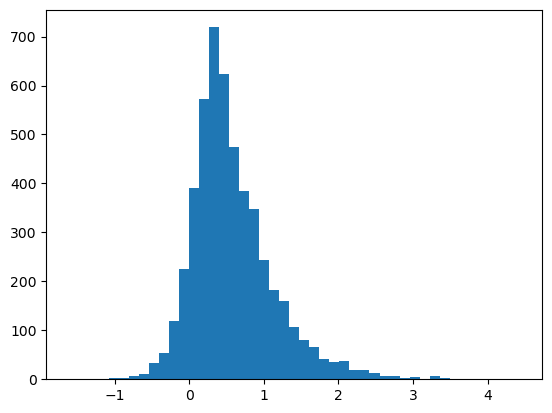

jarzyn = 0.634121437553027, mean work = 0.5838430337297259
[100, 100, 100, 100]


In [36]:
# %%notify
step_time_array = np.cumsum(np.array([x["duration"] for x in protocol_list]))/params['dt']
name_array = [x["name"] for x in protocol_list]


plt.hist(simResult["work_distribution"], bins = 45)
plt.show()
mean_work = np.mean(simResult["work_distribution"])
jarzyn_term = np.mean(np.exp(-simResult["work_distribution"]))
print(f'jarzyn = {jarzyn_term}, mean work = {mean_work}')
print([x["duration"] for x in protocol_list])

2.2370945008300764 0.0002929031342293609
jarzyn = 0.5338519084415347
[200]


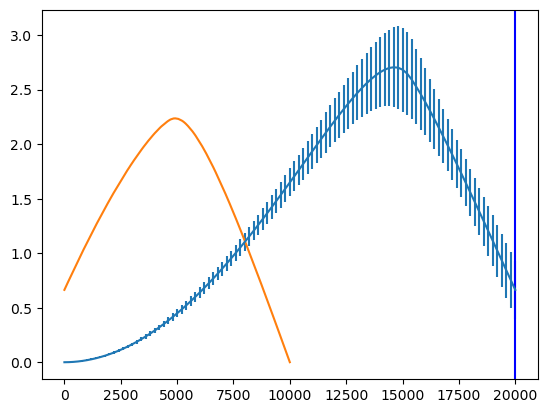

In [123]:


step_array = np.arange(simResult["work_statistic"][:,0].shape[0])
skip_step = int(len(step_array) * 0.01)
work_mean = simResult["work_statistic"][:,0]
work_std = simResult["work_statistic"][:,1]

coarse_step_array = step_array[::skip_step]
coarse_step_array = np.append(coarse_step_array, step_array[-1])
coarse_work_mean_array = work_mean[::skip_step]
coarse_work_mean_array = np.append(coarse_work_mean_array, work_mean[-1])
coarse_work_std_array = np.append(work_std[::skip_step], work_std[-1])

plt.errorbar(coarse_step_array, coarse_work_mean_array, yerr = coarse_work_std_array)

for i, t in enumerate(step_time_array):
    plt.axvline(x = t, color = 'b', label = 'axvline - full height')
    # plt.text('2017-07-02 16:30:00',0.005,'BigNews1',rotation=90,va='top')
    plt.annotate(f"{i+1}", 
            xy=(t, 4.5),  
            # xytext=(quantile_75, 2.05*1e9),
            color='red', 
            ha='center', 
            size=16)



first_half = work_mean[0: len(work_mean)//2]
second_half = work_mean[len(work_mean)//2:][::-1]
abs_error = np.abs(first_half - second_half)
plt.plot(step_array[0:len(step_array)//2], abs_error)
print(max(abs_error), min(abs_error))
print(f'jarzyn = {jarzyn_term}')
print([x["duration"] for x in protocol_list])